# Inspect the dataset
Purpose of this file is to listen to specific samples and inspect the dataset.

1. Load all filenames of a split (train, validation, test) or all files of a split and a specific genre, e.g. test data, genre hiphop.
2. Split and transform the original audio to a mel-spectrogram
3. listen to the audio and plot waveform and mel-spectrogram
4. test dataloaders and display the data augmentation of the train data

In [3]:
import sys
import os
#import pandas as pd
import random
import torch
import torch.nn.functional as F
#import torchvision
import torchaudio
import torchaudio.transforms as tat
from torch.utils.data import TensorDataset, random_split, DataLoader
import numpy as np
import librosa
#import timeit
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio_augmentations import (
    RandomApply,#
    Compose,
    RandomResizedCrop,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Reverse,
    LowPassFilter,
    HighPassFilter,
)


sys.path.append('../')

from utils import load_sample, get_slice, transform_wav_to_mel, plot_spectrogram, rms_normalizer
from utils_folder.visualization import plot_waveform, plot_spec
from models.gtzan_dataset import get_data_loaders
from constants import CLASS_IDX_MAPPER, CLASS_IDX_MAPPER_TOY

In [4]:
PATH_TO_FOLDERS = '/Users/samuelharck/Desktop/masterthesis/data/genres_original/'
PATH_TO_TXT_FILES = '/Users/samuelharck/Desktop/masterthesis/data/'

### Define functions to get specific audio samples

In [2]:
def get_song_list(path_to_txt, split, suffix='all'):
    #if split.startswith('fold'):
    #    list_filename = os.path.join(path_to_txt, '%s_split_%s.txt' % (split, suffix))
    #else:
    list_filename = os.path.join(path_to_txt, '%s_split.txt' % (split) if not split.startswith('fold') else '%s.txt' % (split))
    # only in case of cleaned dataset
    list_filename = os.path.join(path_to_txt, '%s_split_%s.txt' % (split,suffix) if suffix=='cleaned' else list_filename)
    with open(list_filename) as f:
        lines = f.readlines()
    song_list = [line.strip() for line in lines]
    return song_list

def load_songs(path_to_folders, label_dict, songs, genre):
    '''
    Loads all audios of a genre as .wav files
    ____
    Returns:
    List of all audios of a genre
    '''
    all_audios = []
    labels = []
    wav_length = 29

    for name in songs:
        if name.startswith(genre):
            print(name)
            path_to_audio = os.path.join(path_to_folders, name)
            waveform, sample_rate = torchaudio.load(path_to_audio)
            all_audios.append(waveform[:,:(sample_rate*wav_length)])#.flatten()
            # get labels
            genre_name = name.split('/')[0]
            genre_index = label_dict[genre_name]
            labels.append(genre_index)

    return all_audios, labels

def load_split(path_to_txt, path_to_folders, label_dict, split, suffix='all', genre='blues'):
    '''
    Loads all wav files and saves wavs for each genre in dict
    ____
    Returns:
    Dict of all wavs of every genre
    '''
    songs = get_song_list(path_to_txt, split, suffix)
    x_wavs, labels = load_songs(path_to_folders, label_dict, songs, genre)

    return x_wavs, labels

### Get all songs of genre 'hiphop' in test data split

In [4]:
# get test data of genre hiphop
X_test, Y_test = load_split(PATH_TO_TXT_FILES, PATH_TO_FOLDERS, CLASS_IDX_MAPPER, split='fold_5', suffix='all', genre='metal')

metal/metal.00012.wav
metal/metal.00037.wav
metal/metal.00047.wav
metal/metal.00078.wav
metal/metal.00002.wav
metal/metal.00070.wav
metal/metal.00059.wav
metal/metal.00035.wav
metal/metal.00077.wav
metal/metal.00086.wav
metal/metal.00091.wav
metal/metal.00010.wav
metal/metal.00062.wav
metal/metal.00080.wav
metal/metal.00052.wav
metal/metal.00003.wav
metal/metal.00082.wav
metal/metal.00019.wav
metal/metal.00087.wav
metal/metal.00063.wav


## Listen to a sample

In [5]:
mel_values = {"n_mels": 128,
                "n_fft": 800,
                "hop_length": 360,
                "slice_length": 3,
                "num_chunks": 8}

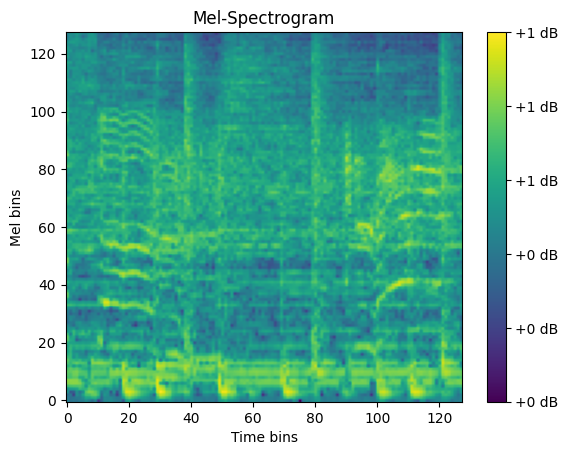

In [10]:
idx = 0
#wav_test, _ = torchaudio.load(os.path.join(PATH_TO_FOLDERS, X_test[idx]))
#resampler = torchaudio.transforms.Resample(22050, 16000)
#wav_test = resampler(wav_test)
#wav = get_slice(wav_test, slice_length=mel_values['slice_length'], start_point=10, sample_rate=16000)



mel, _ = load_sample(os.path.join(PATH_TO_FOLDERS, 'metal/metal.00063.wav'), slice_length=mel_values['slice_length'], start_point=10, num_chunks=1, to_mel=True, case='128_128')
plot_spectrogram(mel.squeeze())

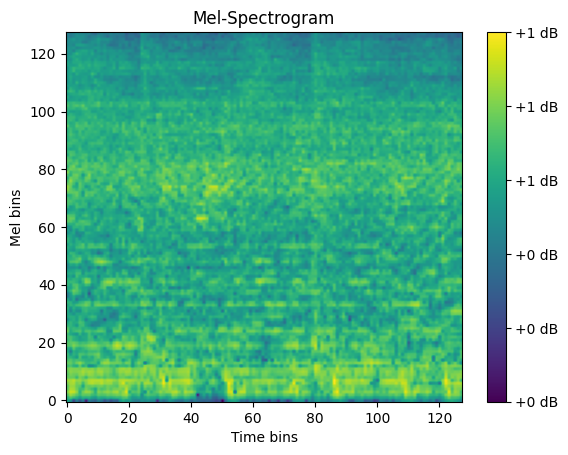

tensor(10203.8086)


In [21]:
mel, _ = load_sample(os.path.join(PATH_TO_FOLDERS, 'metal/metal.00059.wav'), slice_length=mel_values['slice_length'], start_point=10, num_chunks=1, to_mel=True, case='128_128')
plot_spectrogram(mel.squeeze())
print(mel.sum())

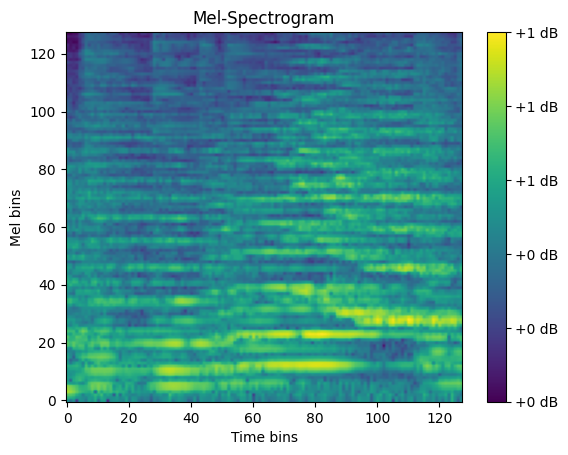

tensor(7655.4570)


In [20]:
mel, _ = load_sample(os.path.join(PATH_TO_FOLDERS, 'classical/classical.00008.wav'), slice_length=mel_values['slice_length'], start_point=10, num_chunks=1, to_mel=True, case='128_128')#, audio_normalization='rms')
plot_spectrogram(mel.squeeze())
print(mel.sum())

In [5]:
mel_values = {"n_mels": 128,
                "n_fft": 1024,
                "hop_length": 512,
                "slice_length": 3,
                "num_chunks": 5}

In [3]:
idx = 0

#wav_test, _ = torchaudio.load(os.path.join(PATH_TO_FOLDERS, 'hiphop/hiphop.00033.wav'))
wav_test, _ = torchaudio.load(os.path.join(PATH_TO_FOLDERS, 'classical/classical.00067.wav'))
#wav = get_slice(wav_test, slice_length=mel_values['slice_length'], start_point=0)
Audio(wav_test.numpy(), rate=22050)

In [4]:
wav_test.min(), wav_test.max()

(tensor(-0.5513), tensor(0.5882))

In [11]:
import soundfile as sf
wav, _ = sf.read(os.path.join(PATH_TO_FOLDERS, 'classical/classical.00061.wav'), dtype='int16')
wav = wav / 32768.0
wav.min(), wav.max()

(-0.59423828125, 0.555419921875)

torch.Size([1, 128, 184])


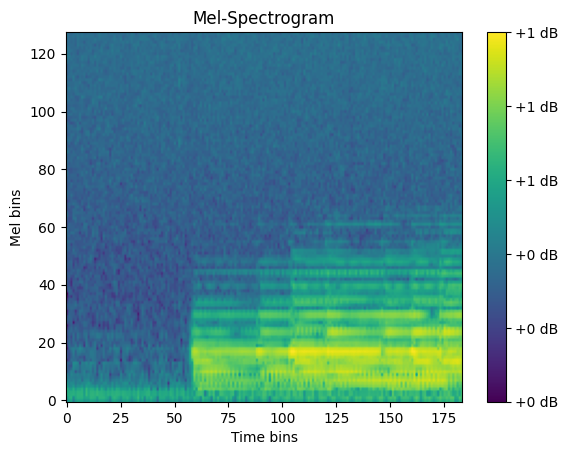

In [20]:
mel = transform_wav_to_mel(wav, n_fft = 800, hop_length=360, audio_normalization=None, normalize=True)
print(mel.size())
plot_spectrogram(mel.squeeze())


In [23]:
resampler = torchaudio.transforms.Resample(22050, 16000)
wav = resampler(wav)

torch.Size([128, 259])


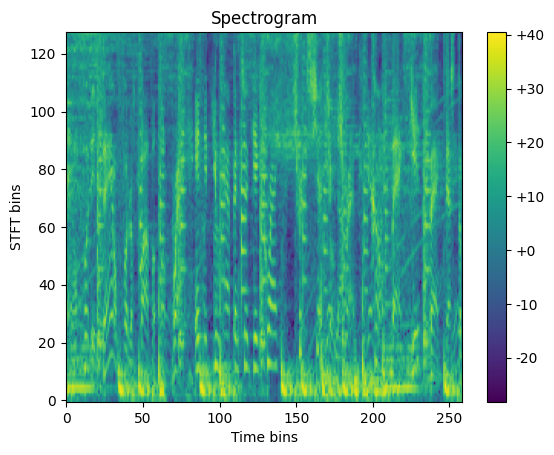

In [11]:
# power spectrogram

wav, sr = torchaudio.load(os.path.join(PATH_TO_FOLDERS, 'hiphop/hiphop.00033.wav'))
wav = get_slice(wav)

meltr = torchaudio.transforms.MelSpectrogram(n_fft=1024, hop_length=512, power=2, f_max=4000)
amp = torchaudio.transforms.AmplitudeToDB()
mel = meltr(wav).squeeze()
mel = amp(mel)
print(mel.size())
plot_spectrogram(mel, title='Spectrogram', db_scale=False, ylabel='STFT bins')

torch.Size([128, 259])


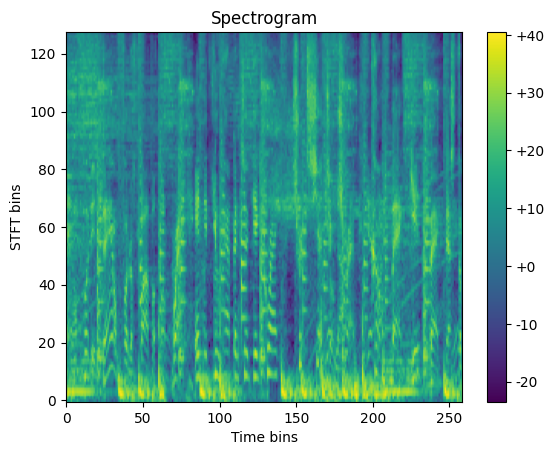

In [10]:
meltr = torchaudio.transforms.MelSpectrogram(n_fft=1024, hop_length=512, power=2, f_max=8000)
amp = torchaudio.transforms.AmplitudeToDB()
mel = meltr(wav).squeeze()
mel = amp(mel)
print(mel.size())
plot_spectrogram(mel, title='Spectrogram', db_scale=False, ylabel='STFT bins')

### TODO: 
- table with rms per genre
- boxplot with amplitude range per genre
- change 20 to 10 if no reliable reference is found

In [7]:
def print_signal_stats(name, data):
    rms = (data**2).mean().sqrt()
    print(name + ':')
    print(f'Min: {data.min():6.3f}, Max: {data.min():6.3f}, RMS: {rms:6.3f}')

metal_sample, _ = torchaudio.load(os.path.join(PATH_TO_FOLDERS, 'metal/metal.00067.wav'))
metal_slice = get_slice(metal_sample, slice_length=mel_values['slice_length'], start_point=0)

classical_sample, _ = torchaudio.load(os.path.join(PATH_TO_FOLDERS, 'classical/classical.00061.wav'))
classical_slice = get_slice(classical_sample, slice_length=mel_values['slice_length'], start_point=0)

print_signal_stats('Metal', metal_slice)
print_signal_stats('Classical', classical_slice)

Metal:
Min: -0.717, Max: -0.717, RMS:  0.145
Classical:
Min: -0.140, Max: -0.140, RMS:  0.026


In [8]:
metal_slice_normalized = rms_normalizer(metal_slice)
classical_slice_normalized = rms_normalizer(classical_slice)

print_signal_stats('Metal', metal_slice_normalized)
print_signal_stats('Classical', classical_slice_normalized)

Metal:
Min: -4.958, Max: -4.958, RMS:  1.000
Classical:
Min: -5.322, Max: -5.322, RMS:  1.000


# Plot representations

In [16]:
wav_sample = metal_slice

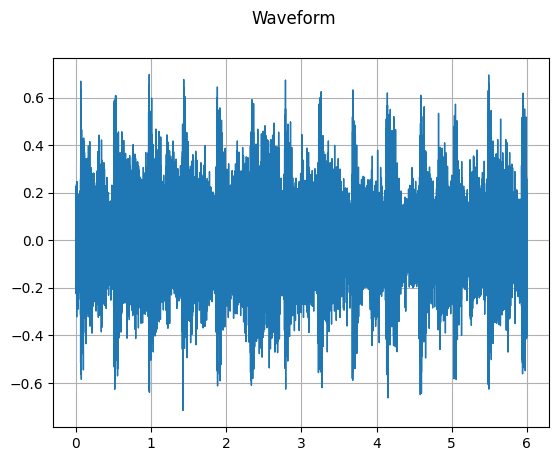

In [15]:
plot_waveform(wav_sample)

# Raw audio to spectrogram - torch

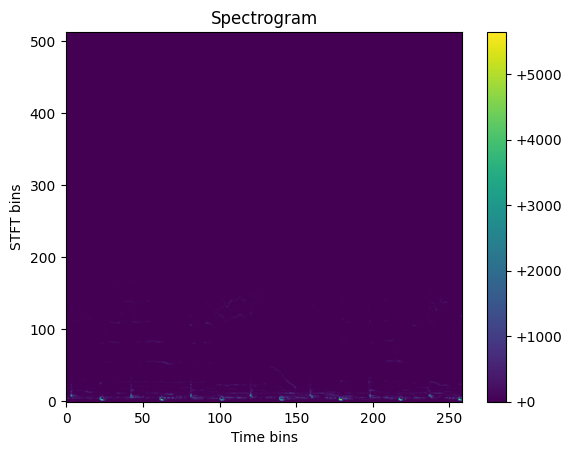

In [60]:
# power spectrogram
spec_transform = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512, power=2)
spec = spec_transform(wav_sample).squeeze()
plot_spectrogram(spec, title='Spectrogram', db_scale=False, ylabel='STFT bins')

In [67]:
stft = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512, power=None)
spec = stft(wav_sample).squeeze()
spec

tensor([[-5.6422e+00+0.0000e+00j, -2.8678e+00+0.0000e+00j,
         -2.9915e+00+0.0000e+00j,  ...,
         -4.7184e-01+0.0000e+00j, -2.4562e+00+0.0000e+00j,
         -1.1711e+01+0.0000e+00j],
        [ 4.2527e+00+5.1688e-07j,  1.1878e+00-2.4213e-01j,
          1.7820e+00-1.0733e+00j,  ...,
          3.2477e+00+1.0637e+01j, -5.7738e+00+1.5220e+01j,
         -4.8576e+00-4.3472e+00j],
        [-2.2700e+00-9.8373e-08j,  1.2975e+00+1.5583e+00j,
         -9.3679e-01+3.0047e+00j,  ...,
         -3.7503e+01-2.6531e+01j,  3.3888e+01-4.9590e+01j,
          3.4248e+01+1.0451e+01j],
        ...,
        [ 1.2645e-02+1.3190e-07j, -9.7990e-05-7.1406e-05j,
         -3.1829e-05-3.7193e-05j,  ...,
         -1.4496e-04+1.1730e-04j, -3.0518e-05-4.1962e-05j,
          1.9701e-02-1.5031e-02j],
        [-1.2748e-02+1.0896e-07j,  5.0604e-05-6.8545e-06j,
         -7.8797e-05+8.8990e-05j,  ...,
          2.7680e-04-1.7071e-04j,  1.6379e-04+3.9101e-05j,
          7.8583e-03+2.3454e-02j],
        [ 1.2804e-02+0

# Spec to Mel - torch

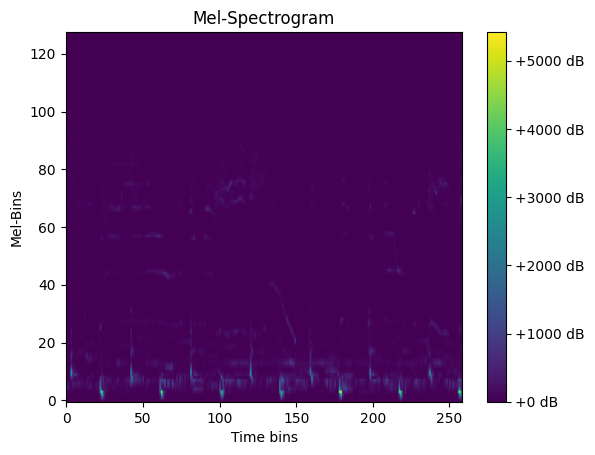

In [61]:
mel_scale = torchaudio.transforms.MelScale(sample_rate=22050, n_stft=513)
mel_spec = mel_scale(spec)
plot_spectrogram(mel_spec)

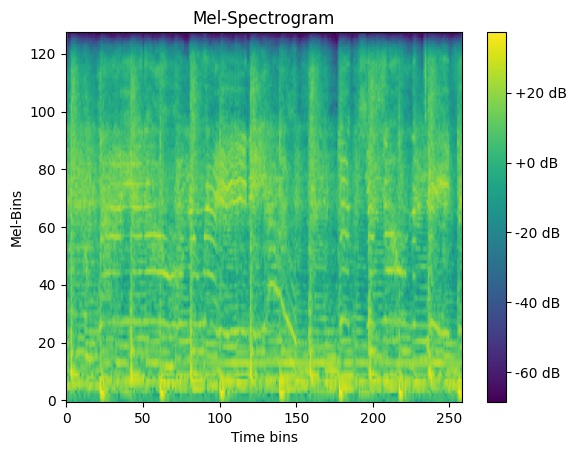

In [63]:
dB_converter = torchaudio.transforms.AmplitudeToDB()
mel_db = dB_converter(mel_spec)
plot_spectrogram(mel_db, db_scale=True)

# Raw audio to spectrogram - librosa

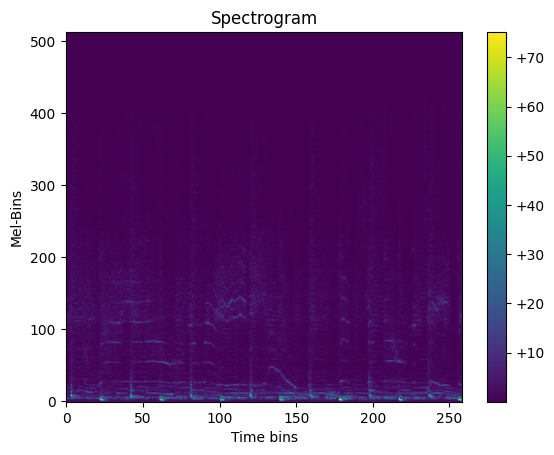

In [45]:
spec_cplx = librosa.stft(wav_sample.cpu().numpy().squeeze(), n_fft=1024, hop_length=512, win_length=1024, pad_mode='reflect')
spec_lib = np.abs(spec_cplx)
plot_spectrogram(spec_lib, title='Spectrogram', db_scale=False)

# Spec to mel - librosa

(128, 513)


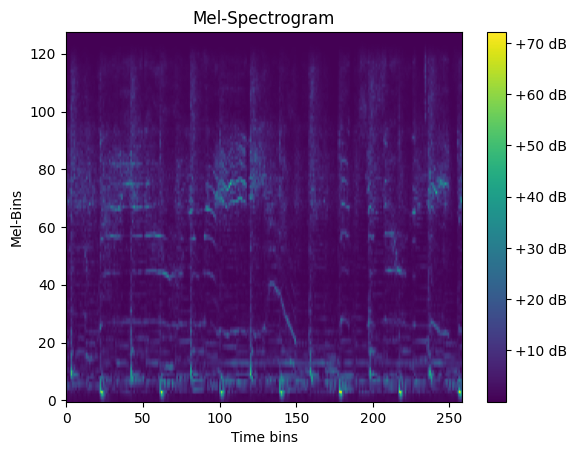

In [39]:
mel_lib = librosa.filters.mel(sr=22050, n_fft=1024, htk=True, norm=None)
print(mel_lib.shape)
plot_spectrogram(mel_lib.dot(spec_lib))

# Raw audio to Mel (no normaliaztion)

torch.Size([128, 256])


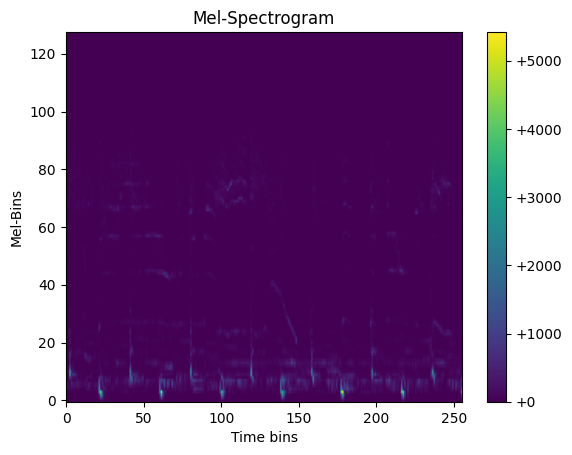

In [46]:
# first we generate the mel spectrogram without log scale and normaliaztion
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512)
mel = mel_converter(wav_sample).squeeze()
# discard firts and last 2 time bins to get desired shape
mel = mel[..., 1:-2]
print(mel.size())
plot_spectrogram(mel, db_scale=False)

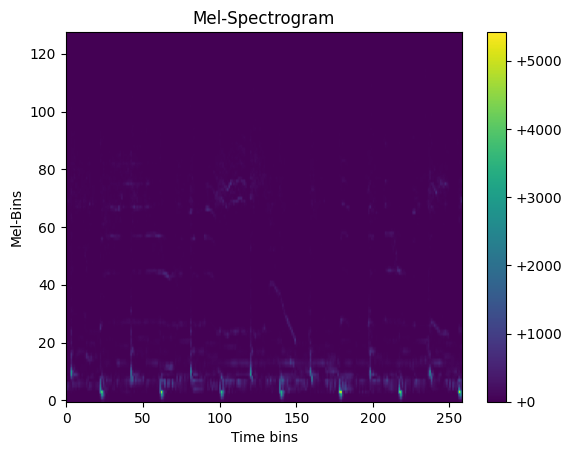

In [56]:
mel_lib_d = librosa.feature.melspectrogram(y=wav_sample.squeeze().cpu().numpy(), sr=22050, n_fft=1024, hop_length=512, pad_mode='reflect', htk=True, norm=None)
plot_spectrogram(mel_lib_d, db_scale=False)

# Mel to dB scale

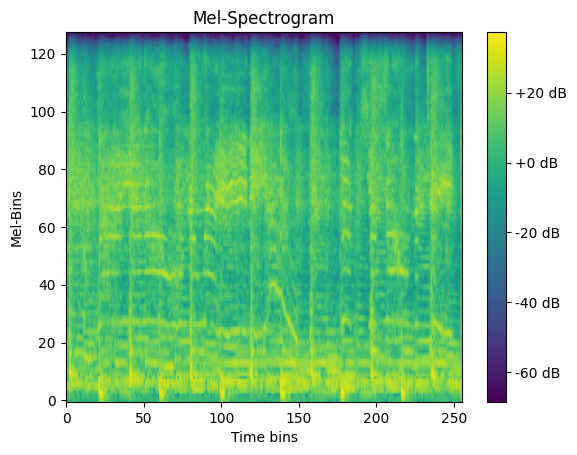

In [57]:
dB_converter = torchaudio.transforms.AmplitudeToDB()
mel_db = dB_converter(mel)
plot_spectrogram(mel_db, db_scale=True)

In [59]:
dB_converter = torchaudio.transforms.AmplitudeToDB()
mel_db = dB_converter(mel_lib_d)
plot_spectrogram(mel_lib_d, db_scale=True)

TypeError: clamp() received an invalid combination of arguments - got (numpy.ndarray, min=float), but expected one of:
 * (Tensor input, Tensor min, Tensor max, *, Tensor out)
 * (Tensor input, Number min, Number max, *, Tensor out)


torch.Size([1, 128, 257])


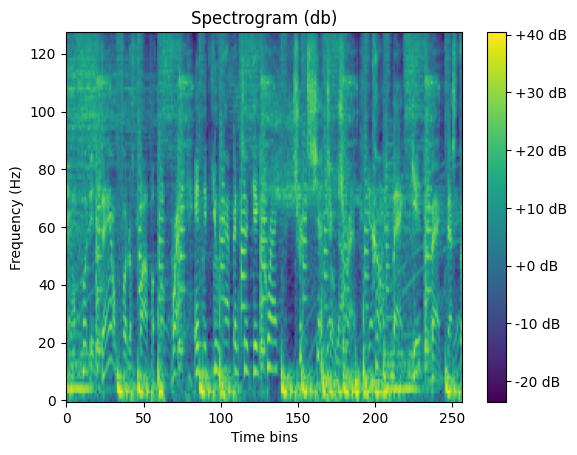

In [6]:
mel = transform_wav_to_mel(wav_sample, sample_rate=22050, n_fft=mel_values['n_fft'], n_mels=mel_values['n_mels'], 
                           normalize=False, set='baseline', hop_length=mel_values['hop_length'])
mel = mel[...,1:-1]
print(mel.size())
plot_spectrogram(mel.squeeze(0))

In [7]:
16000*6

96000

In [72]:
# dafine path to data folders
batch_size = 16
suffix = 'all'
validation_fold = 1

# get data loaders
trainloader, validloader = get_data_loaders(data_path='../../data/', suffix=suffix, batch_size=batch_size,
                                                        n_mels=mel_values["n_mels"], n_fft=mel_values["n_fft"], hop_length=mel_values['hop_length'],
                                                        slice_length=mel_values["slice_length"], num_chunks=mel_values["num_chunks"], 
                                                        cross_valid=True, valid_fold=validation_fold)

# make dataloader iterable
iter_train_loader = iter(trainloader)
iter_valid_loader = iter(validloader)
# get wav file and label from dataloader
Xtrain, Ytrain = next(iter_train_loader)
Xtest, Ytest = next(iter_valid_loader)
# print shapes
print('training data shape: %s' % str(Xtrain.shape))
print('validation/test data shape: %s' % str(Xtest.shape))
print(Ytrain)#, print(test_genre)

training data shape: torch.Size([16, 1, 128, 256])
validation/test data shape: torch.Size([3, 5, 1, 128, 256])
tensor([7, 4, 2, 1, 5, 0, 2, 1, 8, 3, 5, 5, 4, 9, 5, 4])


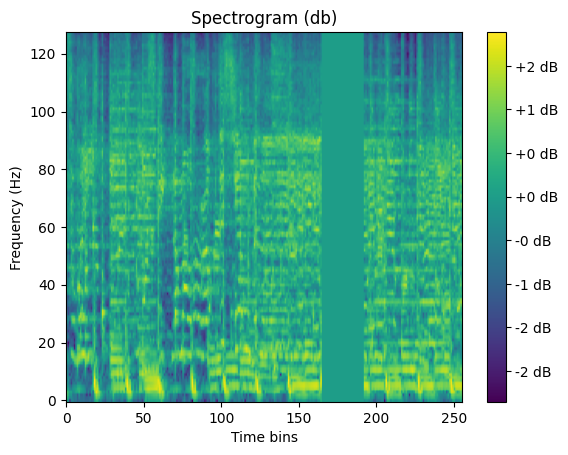

In [80]:
plot_spectrogram(Xtrain[2].squeeze())

## Test inpainting

In [49]:
import random
import cv2

perturbation_size = 32
pertubed_inputs_copy = mel[None]
pertubed_inputs_copy.size()

masks_copy = torch.ones(pertubed_inputs_copy.size())
masks_copy[..., 0:perturbation_size, 0:perturbation_size] = torch.zeros(perturbation_size,perturbation_size)

In [51]:
batch, channel, input_height, input_width = pertubed_inputs_copy.size()

masks = torch.abs(masks_copy - 1)

# Process each image and mask pair
inpainted_images = []

# loop over right images and safe them the right way again in inpainted_images
# with the shape (batch, heigt, width, channel)

# reshape input and mask for cv2 functions (channels have to be in last dimension)
for image, mask in zip(pertubed_inputs_copy.view(batch, input_height, input_width, channel), 
                        masks.view(batch, input_height, input_width, channel)):
    
    image = np.array(image.squeeze(0))
    mask = np.array(mask.squeeze(0)).astype(np.uint8)
    print(image.shape, mask.shape)
    
    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=perturbation_size, flags=cv2.INPAINT_TELEA)
    inpainted_images.append(torch.Tensor(inpainted_image[None]))

    # TODO: CHECK THE APPENDED IMAGES. Are they in right shape or extend instead of append?

# TODO: normalize inpainted input
inpainted_images = torch.stack(inpainted_images, dim=0)
inpainted_images.size()

(128, 256, 1) (128, 256, 1)


torch.Size([1, 1, 128, 256])

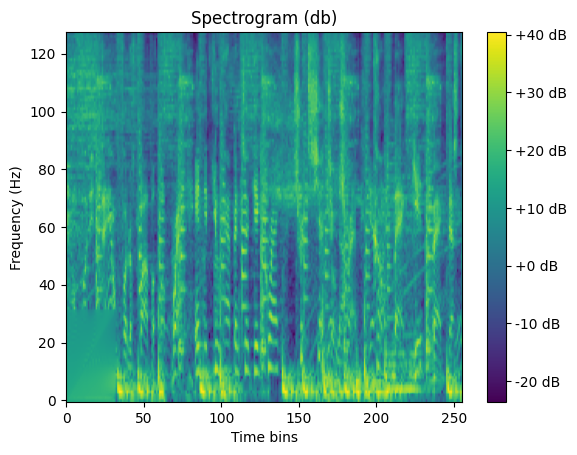

In [52]:
plot_spectrogram(inpainted_images.squeeze(0,1))

## Slice audio
(with get_slice from utils.py)

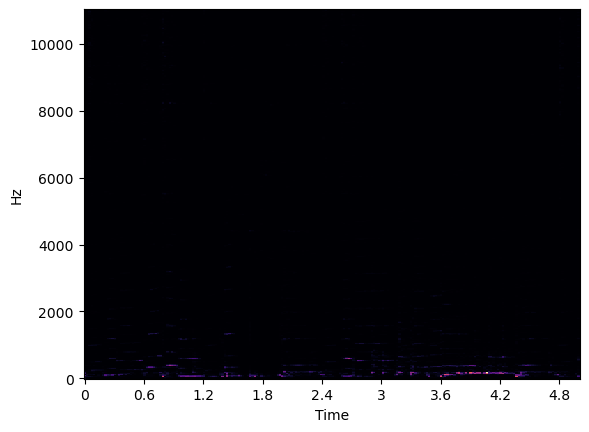

In [19]:
librosa.display.specshow(np.array(spec.squeeze(0)), fmax=11025, y_axis='linear', x_axis='time')

## Transform to mel-spectrogram

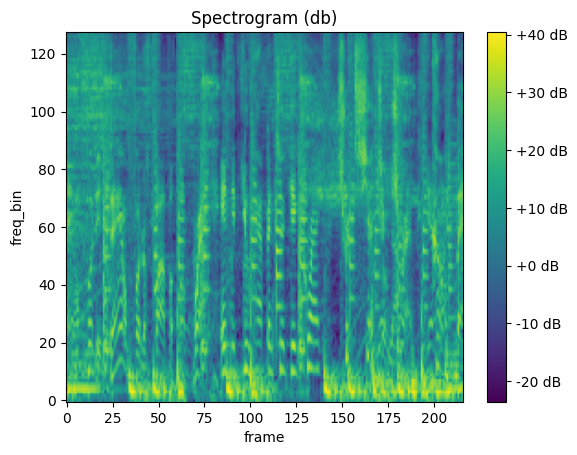

In [19]:
# construct mel
mel_sample = transform_wav_to_mel(wav_sample)
# plot mel
plot_spectrogram(mel_sample.view(128, 216))